# Preprocessing experiments
The point is to investigate whan image processing steps will make for better OCR results.

# Import and constants

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable
import os

import sys
sys.path.append('../')

from services.card_detection import CardDetector
from services.ocr import OCRModel

WEIGHTS_DIR =   '../weights'
TEST_IMAGE_DIR = '../data/credit_card_no_augment_instance_seg/test/images'

c:\Users\vanek\Documents\card_number_finder\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


# Preprocessing steps

In [47]:
def get_grayscale(image: np.ndarray):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def contrast(image: np.ndarray, contrast: int, brightness: int):
    return image * (contrast//127 + 1) - contrast + brightness

def sigmoid(image: np.ndarray):
    image = image/255
    image = 1 / (1 + np.exp(-image))
    return (255*image).astype(np.uint8)

def thresholding(image: np.ndarray):
    return cv2.threshold(image, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def upscale(image: np.ndarray):
    return cv2.resize(image, (0, 0), fx=2, fy=2)

def invert(image: np.ndarray):
    return 255-image if np.mean(image) < 127 else image


In [44]:
card_det_path = os.path.join(WEIGHTS_DIR, 'yolo', 'yolov8m-seg-best.pt')
ocr_path = os.path.join(WEIGHTS_DIR, 'ocr')

detector = CardDetector(card_det_path)
ocr = OCRModel(
    recognizer_path=os.path.join(ocr_path, 'recognizer'),
    detector_path=os.path.join(ocr_path, 'detector'),
    classifier_path=os.path.join(ocr_path, 'angle_classifier'),
    use_angle_classifier=True
)

In [42]:
def show_processing_steps(image, steps: list[Callable]):
    image_ = image.copy()
    cropped = detector.get_card_images(image_)[0] # use the first card for simplicity
    ocr_result = ocr.get_card_number(cropped)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, len(steps)+1, 1)
    plt.axis('off')
    plt.title(f'Original({ocr_result['card_number']})')
    plt.imshow(cropped)
    for idx, step in enumerate(steps, start=2):
        cropped = step(cropped)
        ocr_result = ocr.get_card_number(cropped)
        plt.subplot(1, len(steps)+1, idx)
        plt.axis('off')
        plt.title(f'{step.__name__}({ocr_result["card_number"]})')
        plt.imshow(cropped, cmap='gray')
    plt.show()
    return image

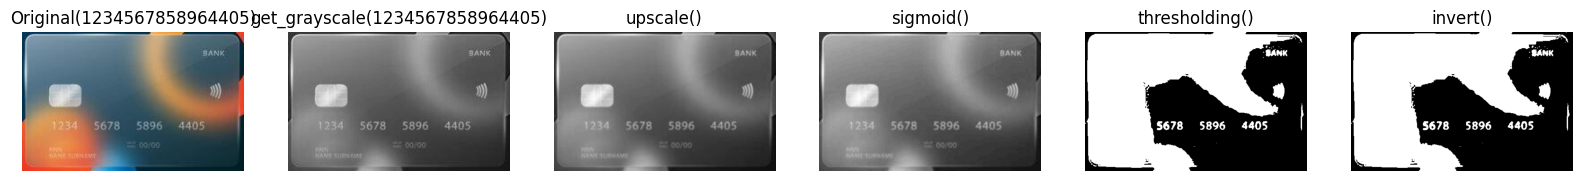

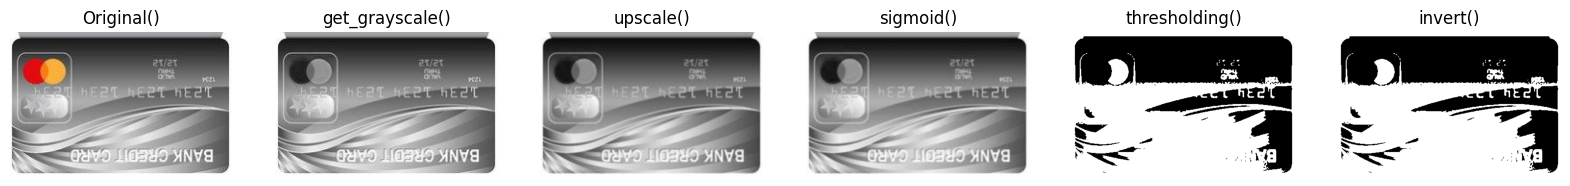

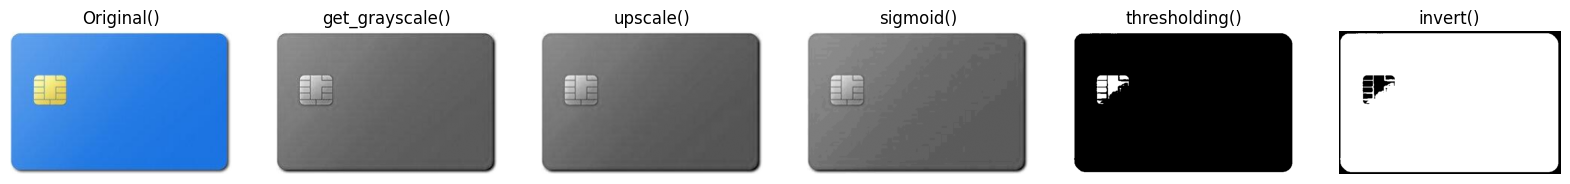

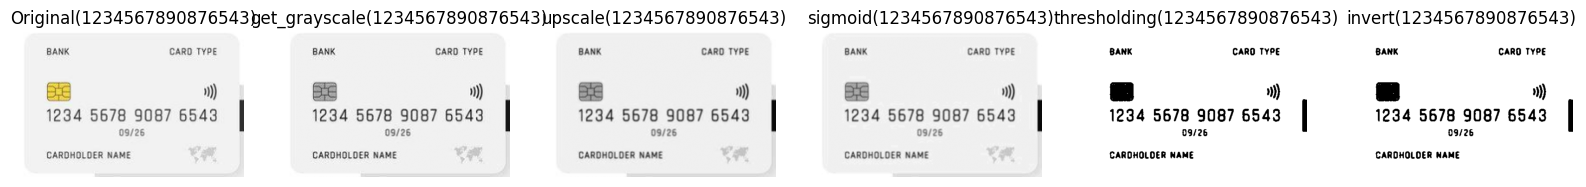

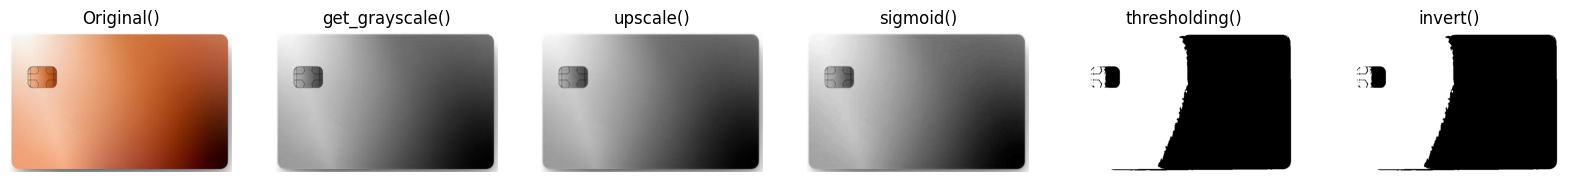

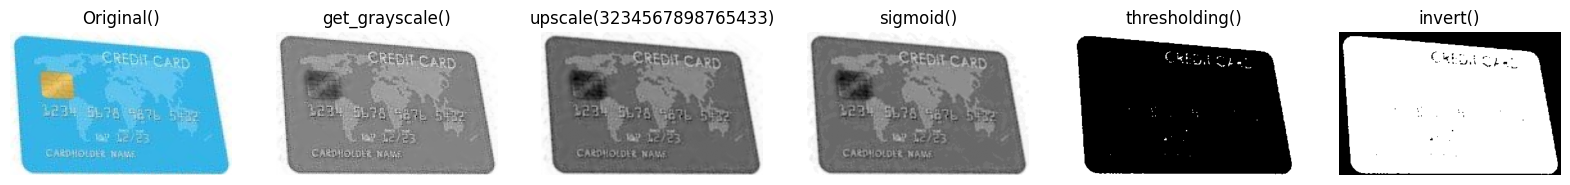

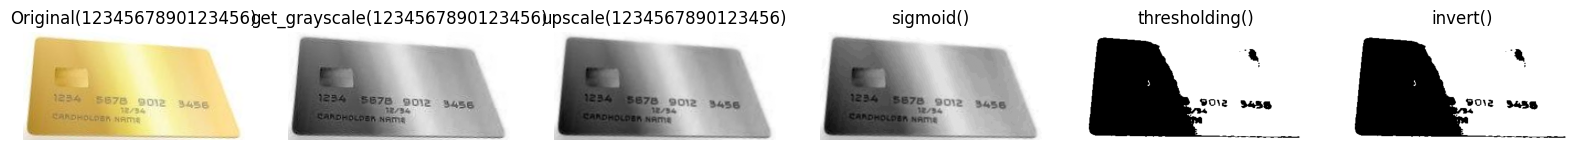

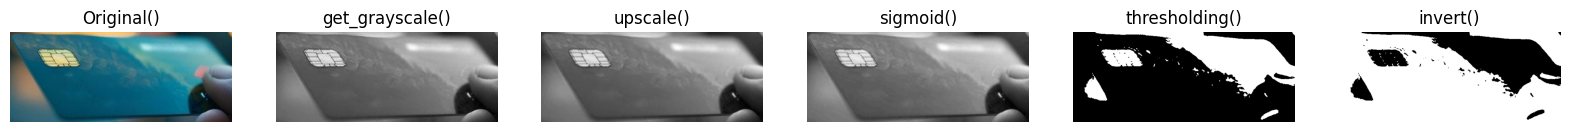

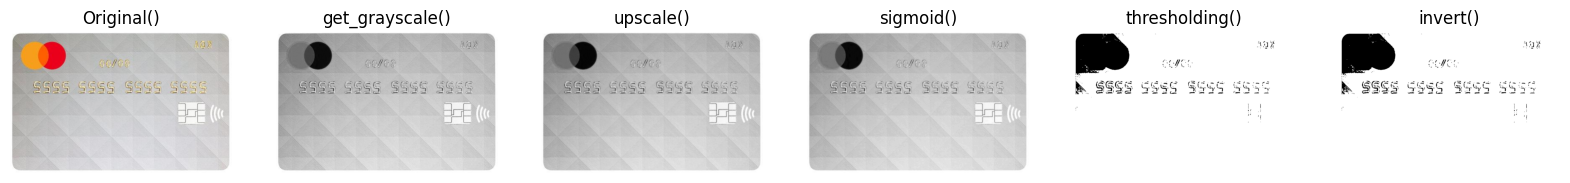

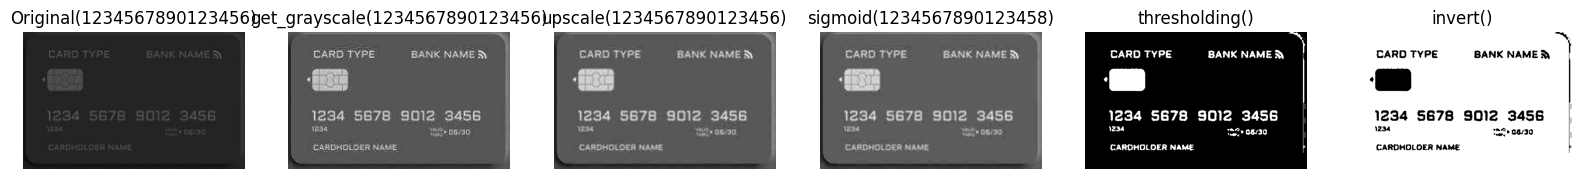

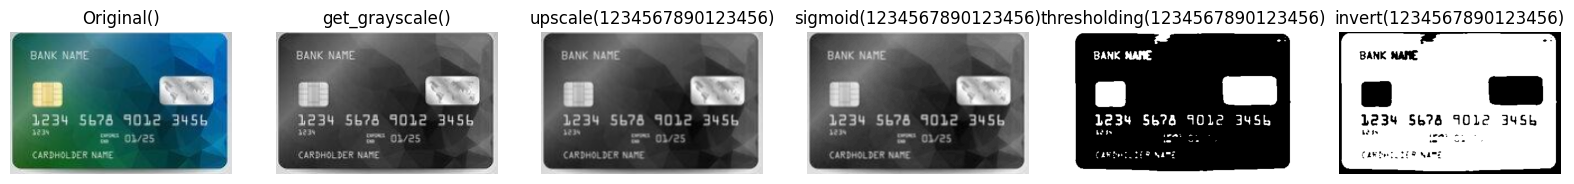

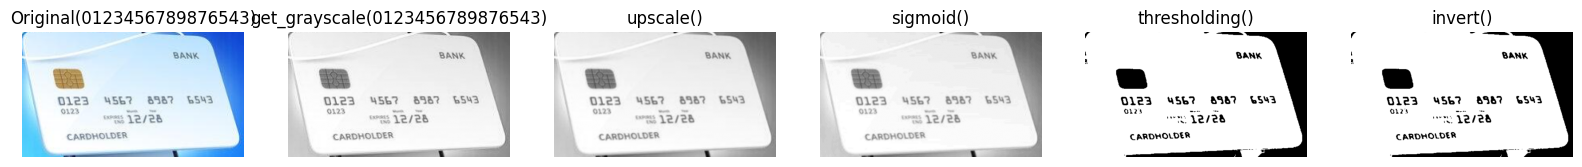

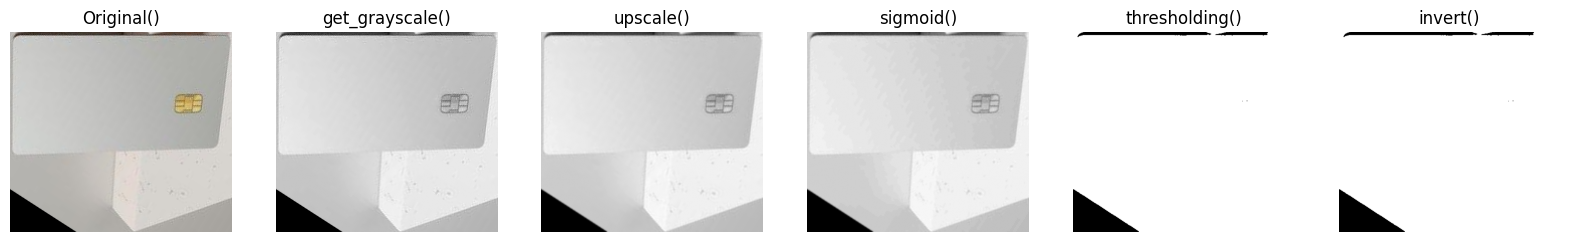

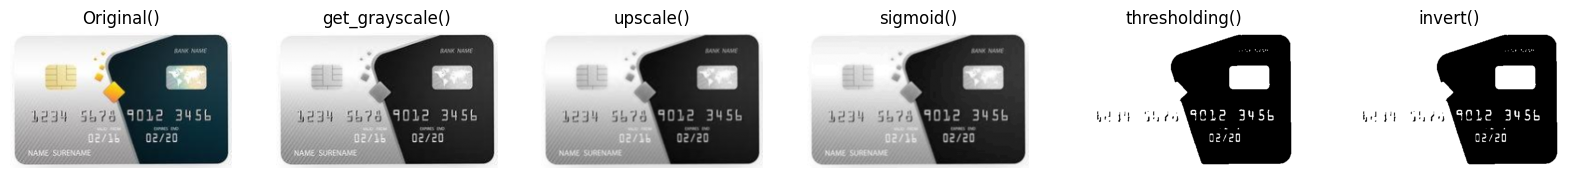

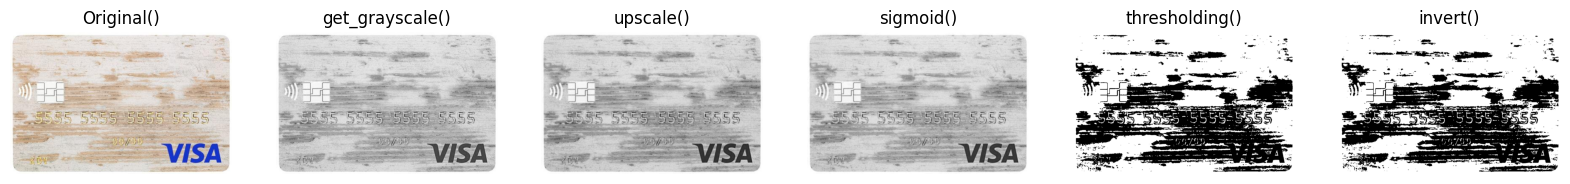

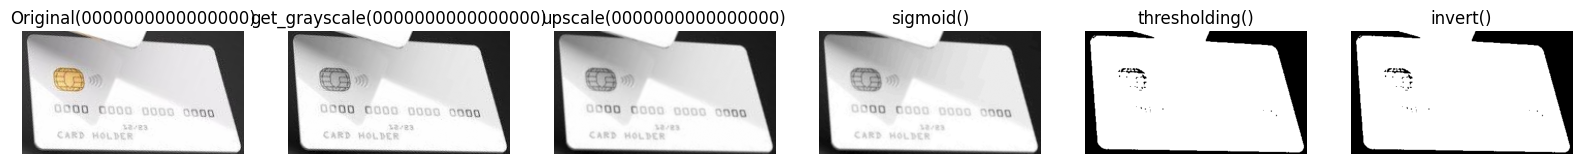

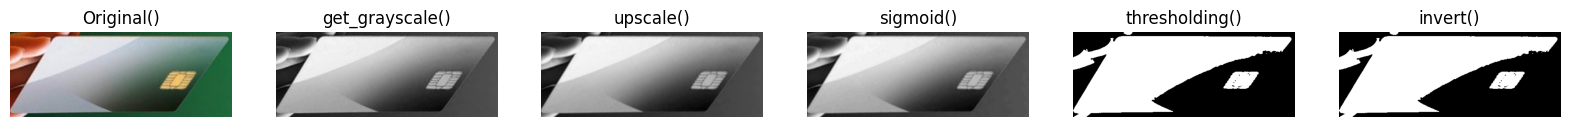

In [48]:
steps = [get_grayscale, upscale, sigmoid, thresholding, invert]

for filename in os.listdir(TEST_IMAGE_DIR)[::3]:
    img = cv2.imread(os.path.join(TEST_IMAGE_DIR, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    show_processing_steps(img, steps)